# Risk comparison (individual values)

Here we consider some basic examples illustrating how different risks respond to different degrees of location/dispersion change.

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.optimize import minimize_scalar

## Internal modules.
from mml.utils import makedir_safe
from setup_sims import bracket_prep, data_all, data_bounded, data_heavytails, data_symmetric, data_unbounded, gen_data, get_entropic, get_obfn
from setup_results import img_dir, my_fontsize, my_ext, export_legend

In [2]:
## Setup: create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Prepare seed sequence; lets us align datasets across different tests.
entropy = 21281555010861417500927421083615113141
ss = np.random.SeedSequence(entropy=entropy)

In [4]:
## Specify the data to be generated.
n = 10000
data_asym = "weibull-unitvar" #"gamma-unitvar" "weibull-unitvar"
data_sym = "normal-sharp"
data_labels = [r"$A$", r"$A^{\prime}$", r"$S$"]

In [5]:
## Specify the risk functions to be used.

todo_risks = ["trisk", "cvar", "entropic", "dro"]
todo_riskparas = {
    "trisk": {"alpha": 1.0, "sigma": 0.1, "etatilde": 1.0},
    "cvar": {"prob": 0.95},
    "entropic": {"gamma": 1.5},
    "dro": {"atilde": 0.95}
}
risk_colors = {"trisk": "xkcd:red",
               "cvar": "xkcd:blue",
               "entropic": "xkcd:cyan",
               "dro": "xkcd:magenta"}

def compute_risk(x_values, name, paras):
    obfn = get_obfn(name=name)
    bracket_low, bracket_mid, bracket_high = bracket_prep(
        x=x_values, paras=paras, obfn_name=name, verbose=False
    )
    opt_result = minimize_scalar(fun=obfn,
                                 bracket=(bracket_low, bracket_mid, bracket_high),
                                 bounds=(bracket_low, bracket_high),
                                 args=(x_values, paras),
                                 method="bounded",
                                 options={"xatol": 1e-10})
    return (opt_result.x, opt_result.fun)

In [6]:
## Generate some data 
rg = np.random.default_rng(seed=ss)
x_asym = gen_data(n=n, name=data_asym, rg=rg)
x_asym = x_asym-np.mean(x_asym)
x_asym_flip = -np.copy(x_asym)
x_sym = gen_data(n=n, name=data_sym, rg=rg)
x_sym = x_sym-np.mean(x_sym)

data_dict = {data_labels[0]: x_asym,
             data_labels[1]: x_asym_flip,
             data_labels[2]: x_sym}

## Prepare storage for risk values.
risk_values = { risk: {data_label: [] for data_label in data_labels} for risk in todo_risks}
print(risk_values)

## Compute and store various risk values.
for risk in todo_risks:
    for data_label in data_labels:
        locval, riskval = compute_risk(x_values=data_dict[data_label],
                                       name=risk,
                                       paras=todo_riskparas[risk])
        risk_values[risk][data_label] += [locval]
print(risk_values)

{'trisk': {'$A$': [], '$A^{\\prime}$': [], '$S$': []}, 'cvar': {'$A$': [], '$A^{\\prime}$': [], '$S$': []}, 'entropic': {'$A$': [], '$A^{\\prime}$': [], '$S$': []}, 'dro': {'$A$': [], '$A^{\\prime}$': [], '$S$': []}}
{'trisk': {'$A$': [-0.372352741149392], '$A^{\\prime}$': [0.1471869882875309], '$S$': [-0.06658442237904554]}, 'cvar': {'$A$': [2.008722461333754], '$A^{\\prime}$': [1.0840473540155304], '$S$': [0.812293697252348]}, 'entropic': {'$A$': [3.680515281619093], '$A^{\\prime}$': [0.4327379982326316], '$S$': [0.1839828528710573]}, 'dro': {'$A$': [3.757060790376553], '$A^{\\prime}$': [1.1876834008730783], '$S$': [1.3144214935295813]}}


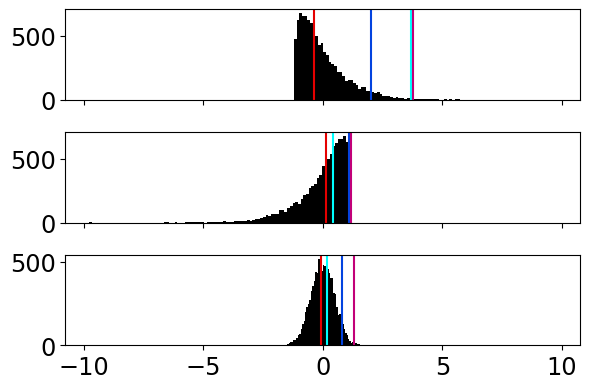

In [7]:
## Plot the data histograms with risk values.
fig, axes = plt.subplots(len(data_dict), 1, figsize=(6,4), sharex=True)
for i, ax in enumerate(axes):
    data_label = data_labels[i]
    ax.hist(data_dict[data_label],
            bins="auto", color="black", hatch=None,
            orientation="vertical", density=False)
    ax.tick_params(labelsize=my_fontsize)
    for risk in todo_risks:
        ax.axvline(risk_values[risk][data_label], color=risk_colors[risk], ls="solid")
    #ax.set_xlabel("Simulated l", size=my_fontsize)
    #ax.set_title(data, size=my_fontsize)
    
plt.tight_layout()
plt.show()


___